# Tourist Guide

## Introduction

When travelling, different people come with different tastes. Some people travel to visit historical places and museums, others travel to spend time at famous bars or nightclubs, and more recently, more people have become interested in what is called 'Food Tourism'. Therefore, this project is going to consider a list of large cities from all over the world, and it is going to group them according to the type of tourism they offer.

This recommender system can be of interest to tourists from all over the globe, who are willing to get some suggestions regarding cities to visit which satisfy their touristic interests. 

This can also be of interest to people willing to invest in any of these categories of tourism (historical places/museums, bars\nightclubs and food), as it helps them to choose between cities where each of these categories is booming or those which the market that has not saturated yet and can still accept more investment to boom. The Foursquare API can be used to obtain the list of venues for each of the cities considered.

## Data Description

### Data Sources

The list of different cities in the world is obtained from the 'World City Database' from the site
https://simplemaps.com/data/world-cities

The dataset has been built from the ground up using authoritative sources such as the NGIA, US Geological Survey, US Census Bureau, and NASA. It was last refreshed in April of 2019. The database contains around 13 thousand entries.

The file containing the list of cities and countries with their corresponding longitutdes and latitudes is in CSV format with no missing data in these columns. This can be imported and then the Foursquare API can be used to get the venues for each city.


### Data Cleaning

The column used to get the names of the cities from the dataset is 'city_ascii' and not the 'city' column to avoid the appearance of special characters that come from different languages. Therefore, the columns to keep are 'city_ascii', 'country', 'lat' and 'lng'. Then, change 'city_ascii; column name into 'city'.

Some city names are repeated, therefore only the first occurance of the city is kept, while the duplicates are dropped.

Since, not all cities will be of interest to tourists due to the lack of venues that belong to the categories (historical places/museums, bars\nightclubs and food), some cities need to be dropped. Our metric to choose the cities to drop will be the total number of hotels, hostels and motels in each city, as it gives a good indication to how touristic this city is. If the total number of touristic residences is equal to zero, the city will be dropped.

In order to decide if a given venue can be considered as an accomodation for tourists or not, the category of the venue will be checked if it belongs to the following list of words (hotel, motel, hostel, auberge, inn, lodge, tavern, guesthouse, B and B, resort, camp, room, appartment, mansion) obtained from
https://www.merriam-webster.com/thesaurus/hotel

https://relatedwords.org/relatedto/hotel

Sometimes, the Foursquare API returns no venues for a given city, or none of the venues belong to the three categories (historical places/museums, bars\nightclubs and food), therefore this city is dropped.

For each of the remaning cities, venues that belong to the three categories will be counted, while other venues will not be included.

For a venue to belong to the 'food' category, it's category needs to have one of the following words (restaurant, bistro, pizza, chicken, beef, seafood, ice cream, sushi, barbeque, noodle, steak, diner, bbq, wings, burger, buffet, grill, grills, grilled, steakhouse, fish, tacos, pasta).

And for a venue to belong to the 'bars\nightclubs' category, it's category needs to have one of the following words (bar, nightclub, liquor, brewery, pub, disco, discotheque, wine, dance, casino, beer, cocktail, cabaret, brasserie, lounge).

Finally, for a venue to belong to the 'historical places/museums', it's category needs to have one of the following words (museum, historical, history, monument, site, historic, monuments, gallery, palace, hall, library, archeological, castle, chateau, fortress, fountain)

#### Import the dataset containing the list of different cities

In [1]:
import csv
import pandas as pd
import requests
import numpy as np

In [2]:
# Convert the csv file into a DataFrame
path = r'C:\Users\amt\Downloads\simplemaps_worldcities_basicv1.5\worldcities.csv'
pd_cities = pd.read_csv(path) 

# Remove unnecessary columns
pd_cities = pd_cities[['city_ascii', 'country', 'lat', 'lng']]

# change city_ascii column name into city
pd_cities.rename(columns={'city_ascii':'city'},inplace=True)
pd_cities.head()
print('There are {} different cities'.format(len(pd_cities)))

There are 12959 different cities


In [3]:
pd_cities.iloc[1000]

city       Mzimba
country    Malawi
lat         -11.9
lng          33.6
Name: 1000, dtype: object

In [4]:
# check if any of the city names are repeated in the dataset
pd_cities['city'].value_counts()

Franklin            11
Clinton             10
Greenville          10
Salem                9
Springfield          9
Washington           9
Richmond             9
Jackson              9
Georgetown           8
Lebanon              8
Hamilton             8
Victoria             8
Monroe               8
Marion               8
Alexandria           7
Plymouth             7
Portland             7
Florence             7
Newport              7
Columbia             7
Auburn               7
Kingston             7
Monticello           6
San Jose             6
Mount Vernon         6
Covington            6
Rochester            6
Lexington            6
Princeton            6
Columbus             6
                    ..
Mingacevir           1
Ubon Ratchathani     1
Koktokay             1
Hidalgo              1
Andorra              1
Dikson               1
Rock Island          1
Jersey Shore         1
Koceljeva            1
Sao Tome             1
Kingsland            1
Islington            1
Vineyard   

In [5]:
# remove duplicates of city
pd_cities.drop_duplicates(subset ="city", inplace = True) 
print('There are {} different cities after removing duplicates'.format(len(pd_cities)))

There are 11555 different cities after removing duplicates


#### Install and import the geopy python package in order to obtain thelongitude and latitude of each of the postal codes

In [6]:
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

In [7]:
pip install folium

Note: you may need to restart the kernel to use updated packages.


In [8]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

import folium # map rendering library

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 

print('Libraries imported.')

Libraries imported.


#### Define functions needed to explore all cities

In [9]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# function that extracts all the venues of a given city and the total number of accomodations
def get_accom_num(latitude,longitude,city,country):
    CLIENT_ID = 'ZXCLYSYUWVNJPEC5ITUIVXFZXHADNFX2FYFNHZE2GEQLP3H1' # your Foursquare ID
    CLIENT_SECRET = 'CPA5PULYPWSCPIVZPPEXQJ2XKRG2CTGNYVNK3IONY2SKJIXI' # your Foursquare Secret
    VERSION = '20180604'
    LIMIT = 1000
    radius = 10000

    # Define url
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'\
    .format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
    
    try:

        # Send GET request
        results = requests.get(url).json()
        items = results['response']['groups'][0]['items']
    
        # Process JSON and convert it to a clean dataframe
        dataframe = json_normalize(items) # flatten JSON
    
        filtered_columns = ['venue.name', 'venue.categories', 'venue.id','venue.location.lat','venue.location.lng']
        dataframe_filtered = dataframe.loc[:, filtered_columns]
    
        # Filter the category for each row
        dataframe_filtered['venue.categories'] = dataframe_filtered.apply(get_category_type, axis=1)

        # Clean columns
        dataframe_filtered.columns = [col.split('.')[-1] for col in dataframe_filtered.columns]
    
        # change the 'categories' column into lower case characters
        dataframe_filtered['categories'] = dataframe_filtered['categories'].str.lower()
    
        # Count number of accomodations that suit tourists
        count_accom = sum(dataframe_filtered['categories'].isin(['hotel','motel','hostel','auberge','inn','lodge','tavern',\
                    'guesthouse', 'B and B', 'resort', 'camp','room','appartment','mansion']))
    except:
        count_accom = 0
        dataframe_filtered = pd.DataFrame()
    
    return dataframe_filtered, count_accom

# function that counts total number of venues that belong to each the three categories 
# (historical places/museums, bars\nightclubs and food)
def count_venues(venues):
    list_foods = ['restaurant', 'bistro', 'pizza','chicken', 'beef', 'seafood', 'ice cream', 'sushi', 'barbeque',\
                  'noodle', 'steak', 'diner','bbq', 'wings', 'burger', 'buffet', 'grill', 'grills', 'grilled','steakhouse',\
                  'fish', 'tacos', 'pasta']
    list_night = ['bar', 'nightclub', 'liquor', 'brewery', 'pub', 'disco', 'discotheque', 'wine', 'dance', 'casino', 'beer',\
                 'cocktail', 'cabaret', 'brasserie', 'lounge']
    list_museum = ['museum', 'historical', 'history', 'monument', 'site', 'historic', 'monuments', 'gallery', 'palace',\
                  'hall', 'library', 'archeological', 'castle', 'chateau', 'fortress', 'fountain']
    
    count_food = 0
    count_night = 0
    count_museum = 0
    try:
        for i in range(0,len(venues)):
            categ = venues.iloc[i]['categories'].split(' ')
            if any(c in set(list_foods) for c in categ):
                count_food += 1
            elif any(c in set(list_night) for c in categ):
                count_night += 1
            elif any(c in set(list_museum) for c in categ):
                count_museum += 1
    except:
        count_food = 0
        count_night = 0
        count_museum = 0
        
    return count_food, count_night, count_museum

In [10]:
# for each city in the dataset which has accomodation for tourists, count the total number of venues that belong to each
# of the three categories we have (historical places/museums, bars\nightclubs and food)

# shuffle the dataset
pd_cities = pd_cities.sample(random_state=0,frac=1).reset_index(drop=True)

#city_info = pd.DataFrame(columns=['city', 'country', 'lat', 'lng', 'count_accom', 'count_food', 'count_night', 'count_museum'])
city_info_list = []
for i in range(0,len(pd_cities)):
    dict1 = {}
    df, count_accom = get_accom_num(pd_cities.iloc[i]['lat'],pd_cities.iloc[i]['lng'],pd_cities.iloc[i]['city'],\
                          pd_cities.iloc[i]['country'])
    # drop cities where there are no hotels
    if count_accom == 0:
        continue
        
    foods, nights, museums = count_venues(df)
    # drop cities where none of the venues belong to our categories of interest
    if foods+nights+museums == 0:
        continue
        
    dict1 = {'city': pd_cities.iloc[i]['city'], 'country':pd_cities.iloc[i]['country'],\
                   'lat':pd_cities.iloc[i]['lat'], 'lng':pd_cities.iloc[i]['lng'], 'count_accom':count_accom,\
                   'count_food':foods, 'count_night':nights, 'count_museum':museums}
    if np.remainder(i+1,500)==0:
        print('City number ', i+1)
        print(dict1)
    city_info_list.append(dict1)

city_info = pd.DataFrame(city_info_list)

City number  1000
{'city': 'Daman', 'country': 'India', 'lat': 20.417, 'lng': 72.85, 'count_accom': 4, 'count_food': 12, 'count_night': 2, 'count_museum': 0}
City number  2000
{'city': 'Caernarfon', 'country': 'United Kingdom', 'lat': 53.15, 'lng': -4.2667, 'count_accom': 2, 'count_food': 4, 'count_night': 7, 'count_museum': 2}
City number  3000
{'city': 'Heath', 'country': 'United States', 'lat': 32.8444, 'lng': -96.4679, 'count_accom': 1, 'count_food': 43, 'count_night': 2, 'count_museum': 0}
City number  3500
{'city': 'Ijebu Ode', 'country': 'Nigeria', 'lat': 6.8204, 'lng': 3.92, 'count_accom': 1, 'count_food': 0, 'count_night': 1, 'count_museum': 0}
City number  4000
{'city': 'New Braunfels', 'country': 'United States', 'lat': 29.6995, 'lng': -98.1153, 'count_accom': 2, 'count_food': 44, 'count_night': 16, 'count_museum': 0}
City number  4500
{'city': 'Phangnga', 'country': 'Thailand', 'lat': 8.451, 'lng': 98.534, 'count_accom': 2, 'count_food': 10, 'count_night': 0, 'count_museum'

In [11]:
city_info.head(10)


,city,count_accom,count_food,count_museum,count_night,country,lat,lng
0,Chesapeake Beach,1,17,0,2,United States,38.6881,-76.5448
1,Saint Anthony,1,37,4,13,United States,45.0278,-93.2174
2,Kamloops,8,21,0,5,Canada,50.6667,-120.3333
3,Lida,1,3,2,3,Belarus,53.8885,25.2846
4,Hohhot,6,2,1,0,China,40.8200,111.6600
5,Leon,2,40,0,8,Mexico,21.1500,-101.7000
6,Wilmington,1,34,5,10,United States,39.7415,-75.5413
7,Tanjungpandan,8,24,4,1,Indonesia,-2.7500,107.6500
8,Marrakesh,23,33,7,11,Morocco,31.6300,-8.0000
9,Santa Cruz do Sul,3,24,0,11,Brazil,-29.7100,-52.4400


In [12]:
print('The total number of cities that fit our selection criteria is {}'.format(len(city_info)))

The total number of cities that fit our selection criteria is 6654


## Methodology

After preprocessing the data from the list of cities database, in addition to their corresponding venues obtained using Foursquare's API, the dataset needs to be explored to get an idea about the different countries that exist in our final dataset, the cities that have the highest number of restaurants, or musuems/historical places or places suitable for night life.

This dataset can give us different insights about how touristic the city is by looking at the number of hotels, we can get an idea about the size of the city or the number of visitors based on the total number of resturants.

### Exploratory Data Analysis

In [68]:
# Combine the two columns of city and country into a single column
city_info['city, country'] = city_info['city'] + ', ' + city_info['country']
city_info.head()

,city,count_accom,count_food,count_museum,count_night,country,lat,lng,"city, country"
0,Oldbury,2,23,5,38,United Kingdom,52.5000,-2.0167,"Oldbury, United Kingdom"
1,Wallsend,4,20,6,36,United Kingdom,54.9914,-1.5597,"Wallsend, United Kingdom"
2,Gateshead,3,26,4,31,United Kingdom,54.9450,-1.6175,"Gateshead, United Kingdom"
3,Cork,2,27,3,30,Ireland,51.8986,-8.4958,"Cork, Ireland"
4,Wolverhampton,2,18,6,30,United Kingdom,52.5833,-2.1333,"Wolverhampton, United Kingdom"


#### Sort cities to get the ones with the highest number of hotels

In [95]:
city_info.sort_values(by='count_accom', axis=0, ascending=False, inplace=True)
city_info.reset_index(drop=True, inplace=True)
city_info.head(10)

,city,count_accom,count_food,count_museum,count_night,country,lat,lng,"city, country"
0,Siem Reap,39,29,3,7,Cambodia,13.3666,103.8500,"Siem Reap, Cambodia"
1,Nevsehir,29,14,1,2,Turkey,38.6240,34.7240,"Nevsehir, Turkey"
2,Bavaro,29,23,0,15,Dominican Republic,18.7170,-68.4500,"Bavaro, Dominican Republic"
3,Stans,27,24,2,1,Switzerland,46.9500,8.3833,"Stans, Switzerland"
4,Da Nang,26,34,0,10,Vietnam,16.0600,108.2500,"Da Nang, Vietnam"
5,Estes Park,25,17,1,6,United States,40.3702,-105.5222,"Estes Park, United States"
6,El Calafate,25,13,0,3,Argentina,-50.3333,-72.3000,"El Calafate, Argentina"
7,Kandy,25,21,1,4,Sri Lanka,7.2800,80.6700,"Kandy, Sri Lanka"
8,Ohrid,24,27,4,14,Macedonia,41.1172,20.8019,"Ohrid, Macedonia"
9,Bocas del Toro,24,18,0,8,Panama,9.3354,-82.2475,"Bocas del Toro, Panama"


It seems that the highest number of hotels criteria is not a good indication of how touristic the city is, since sorting the list of city using this criteria resulted in cities that are not that famous for tourism.

#### Sort cities to get the ones with best nightlife

In [98]:
city_info.sort_values(by='count_night', axis=0, ascending=False, inplace=True)
city_info.reset_index(drop=True, inplace=True)
city_info.head(10)


,city,count_accom,count_food,count_museum,count_night,country,lat,lng,"city, country"
0,Oldbury,2,23,5,38,United Kingdom,52.5000,-2.0167,"Oldbury, United Kingdom"
1,Wallsend,4,20,6,36,United Kingdom,54.9914,-1.5597,"Wallsend, United Kingdom"
2,Gateshead,3,26,4,31,United Kingdom,54.9450,-1.6175,"Gateshead, United Kingdom"
3,Wolverhampton,2,18,6,30,United Kingdom,52.5833,-2.1333,"Wolverhampton, United Kingdom"
4,Cork,2,27,3,30,Ireland,51.8986,-8.4958,"Cork, Ireland"
5,Galway,9,24,0,29,Ireland,53.2724,-9.0488,"Galway, Ireland"
6,Katerini,6,31,0,28,Greece,40.2723,22.5025,"Katerini, Greece"
7,Bradford,2,28,4,28,United Kingdom,53.8000,-1.7500,"Bradford, United Kingdom"
8,Walsall,4,13,4,28,United Kingdom,52.6000,-2.0000,"Walsall, United Kingdom"
9,Birmingham,2,27,4,28,United Kingdom,52.4750,-1.9200,"Birmingham, United Kingdom"


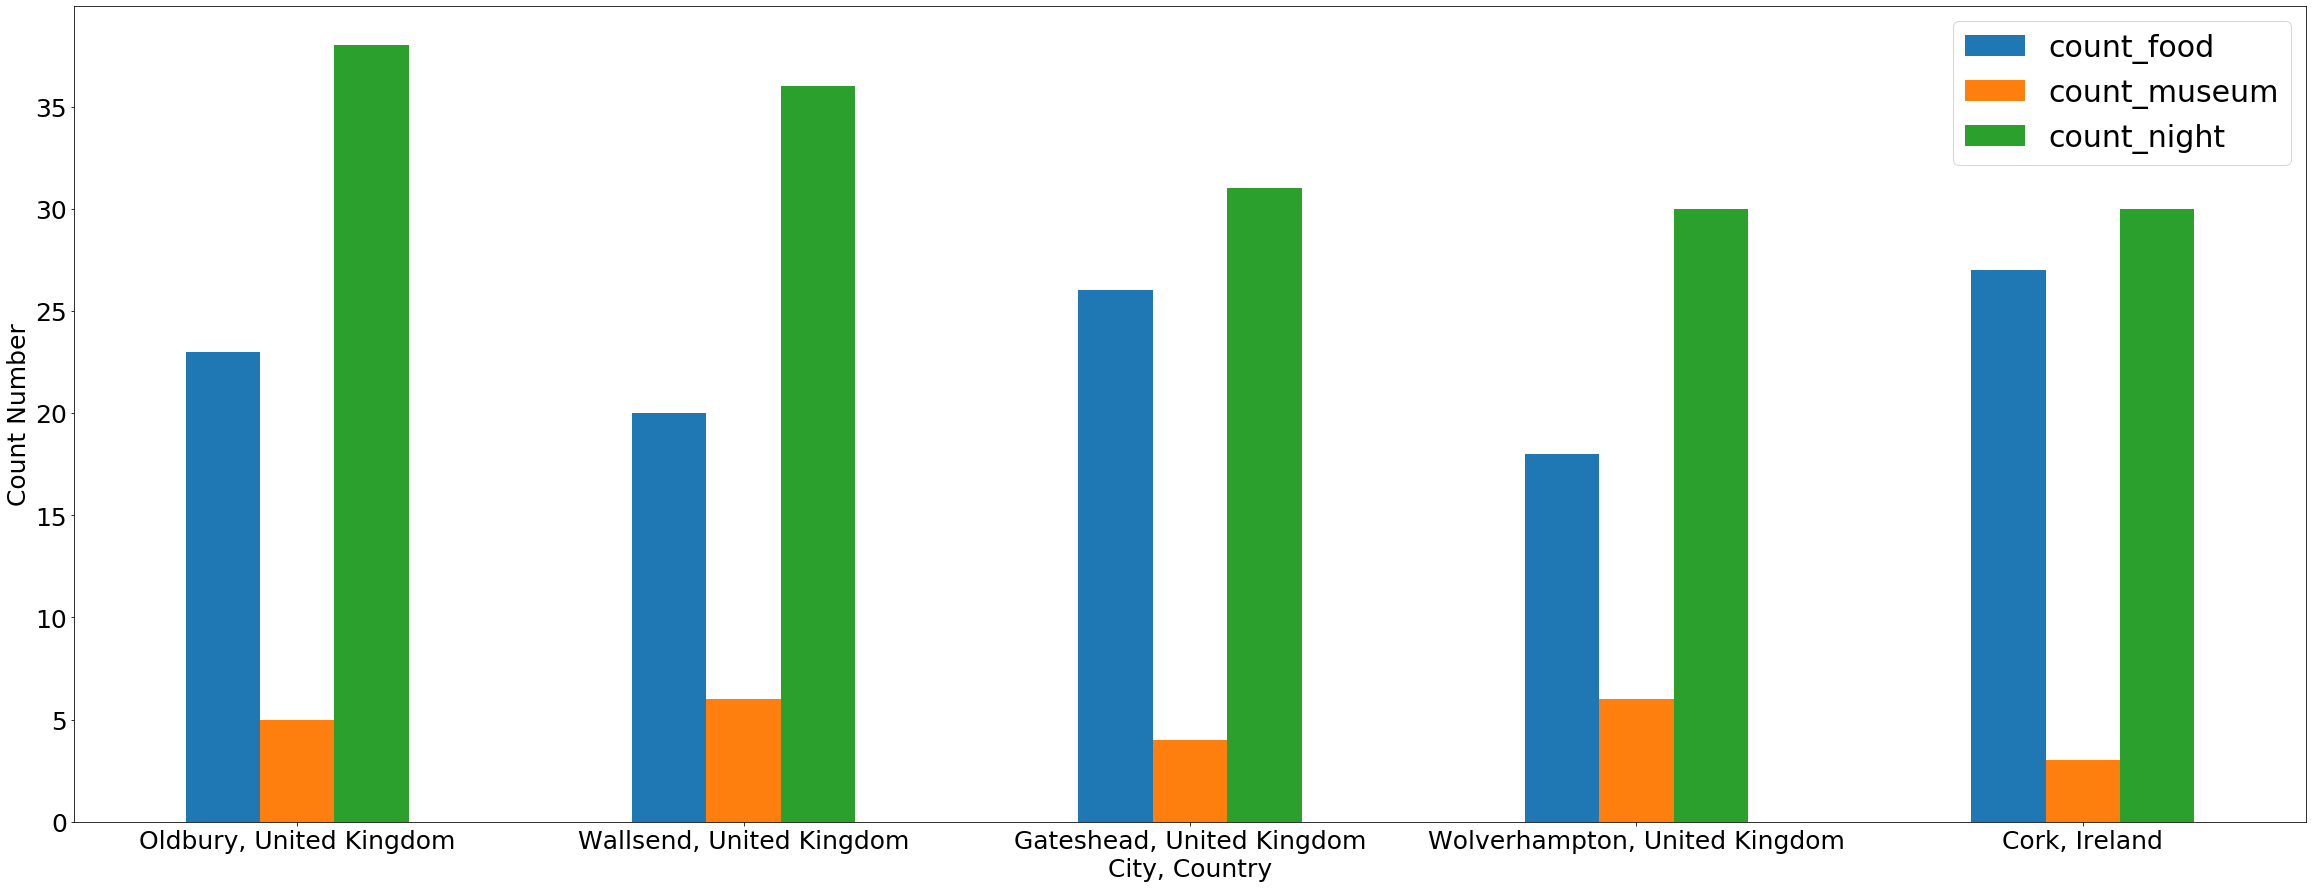

In [101]:
# Plot bar plot of the top 5 cities
city_plot = city_info[['city','count_food','count_museum','count_night','city, country']]
ax = city_plot.iloc[:5].plot.bar(rot=0,figsize=(40,15))
ax.set_xlabel('City, Country', size=25)
ax.set_ylabel('Count Number', size=25)
ax.set_xticklabels(city_plot['city, country'])
ax.tick_params(axis='both', which='major', labelsize=25)
ax.legend(fontsize=30)

The results shown in the bar plot above shows that the united kingdom is dominating the top 5 list when it comes to nightlife. Also, note that cities that have rich nightlife tend to have high number of restaurants too, which makes sense, since when the number of bars, pubs, nightclubs and casino attendees increases, more restaurants are needed to serve them as well.

#### Sort cities to get the ones with the most historical places

In [105]:
city_info.sort_values(by=['count_museum'], axis=0, ascending=False, inplace=True)
city_info.reset_index(drop=True, inplace=True)
city_info.head(10)


,city,count_accom,count_food,count_museum,count_night,country,lat,lng,"city, country"
0,Rome,1,14,25,6,Italy,41.8960,12.4833,"Rome, Italy"
1,Potsdam,3,22,22,8,Germany,52.4004,13.0700,"Potsdam, Germany"
2,Luxor,10,14,19,2,Egypt,25.7000,32.6500,"Luxor, Egypt"
3,Gettysburg,7,18,19,11,United States,39.8304,-77.2339,"Gettysburg, United States"
4,Beijing,17,28,19,8,China,39.9289,116.3883,"Beijing, China"
5,Washington,6,23,18,8,United States,38.9047,-77.0163,"Washington, United States"
6,Ankara,1,14,18,13,Turkey,39.9272,32.8644,"Ankara, Turkey"
7,Diyarbakir,6,22,18,4,Turkey,37.9204,40.2300,"Diyarbakir, Turkey"
8,St. Petersburg,8,2,17,9,Russia,59.9390,30.3160,"St. Petersburg, Russia"
9,Al Quds,15,19,17,7,West Bank,31.7764,35.2269,"Al Quds, West Bank"


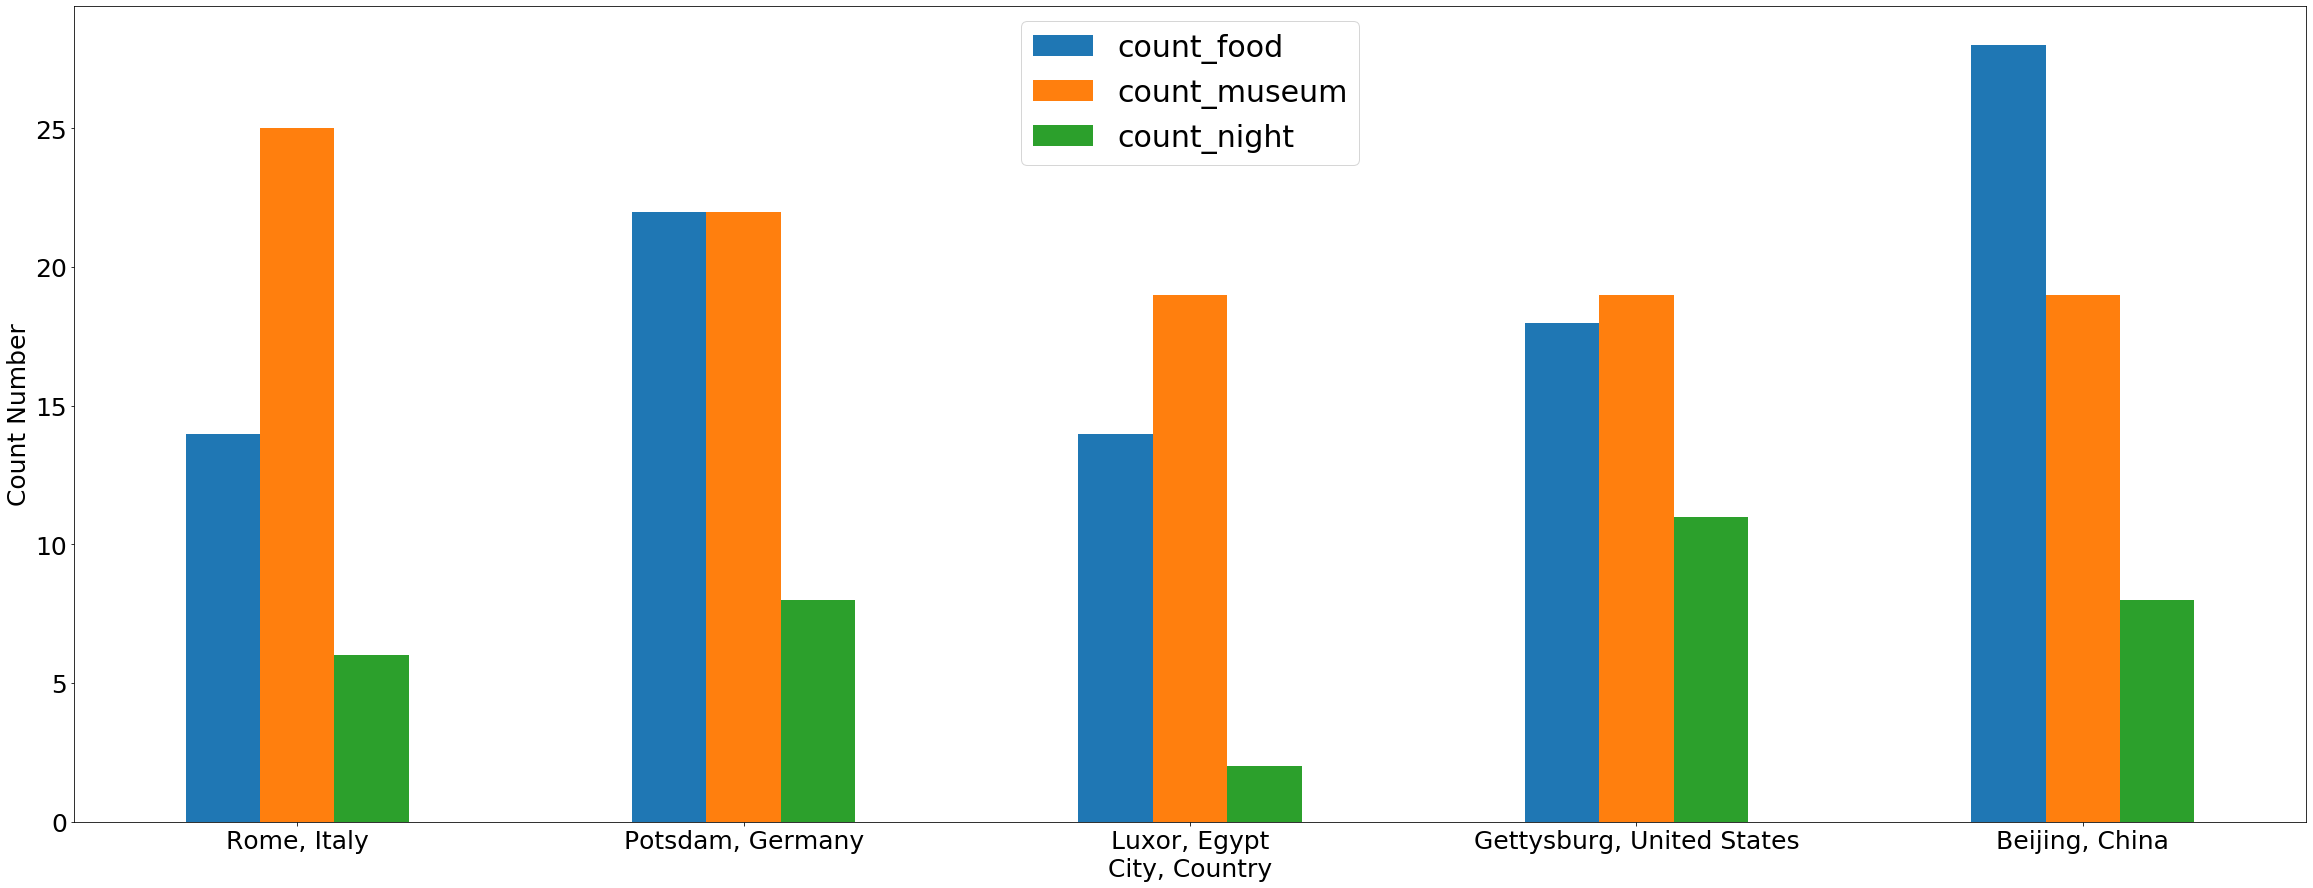

In [106]:
# Plot bar plot of the top 5 cities
city_plot = city_info[['city','count_food','count_museum','count_night','city, country']]
ax = city_plot.iloc[:5].plot.bar(rot=0,figsize=(40,15))
ax.set_xlabel('City, Country', size=25)
ax.set_ylabel('Count Number', size=25)
ax.set_xticklabels(city_plot['city, country'])
ax.tick_params(axis='both', which='major', labelsize=25)
ax.legend(fontsize=30)

We notice a cultural diversity when sorting cities based on the number of historical sites available. However, even though the number of historical sites is greater than that of nightlife venues, the number of restaurants is still high enough and competes with the number of historical sites. This makes it less clear when clustering cities that are well known for their historical sites.

#### Sort cities to get the ones with best food tourism

In [117]:
city_info.sort_values(by='count_food', axis=0, ascending=False, inplace=True)
city_info.reset_index(drop=True, inplace=True)
city_info.head(10)


,city,count_accom,count_food,count_museum,count_night,country,lat,lng,"city, country",trending_food
0,South El Monte,1,63,0,2,United States,34.0493,-118.0484,"South El Monte, United States",0
1,Jacinto City,1,61,0,5,United States,29.7663,-95.2410,"Jacinto City, United States",0
2,Galena Park,1,59,0,4,United States,29.7452,-95.2333,"Galena Park, United States",0
3,South Houston,1,58,1,3,United States,29.6611,-95.2285,"South Houston, United States",0
4,Utsunomiya,2,58,3,2,Japan,36.5500,139.8700,"Utsunomiya, Japan",0
5,Chon Buri,1,57,0,2,Thailand,13.4004,101.0000,"Chon Buri, Thailand",0
6,Fukuoka,7,56,3,6,Japan,33.5950,130.4100,"Fukuoka, Japan",0
7,Addison,1,56,1,3,United States,32.9587,-96.8356,"Addison, United States",0
8,Marbella,4,55,1,7,Spain,36.5166,-4.8833,"Marbella, Spain",0
9,Kangar,4,55,1,1,Malaysia,6.4330,100.1900,"Kangar, Malaysia",0


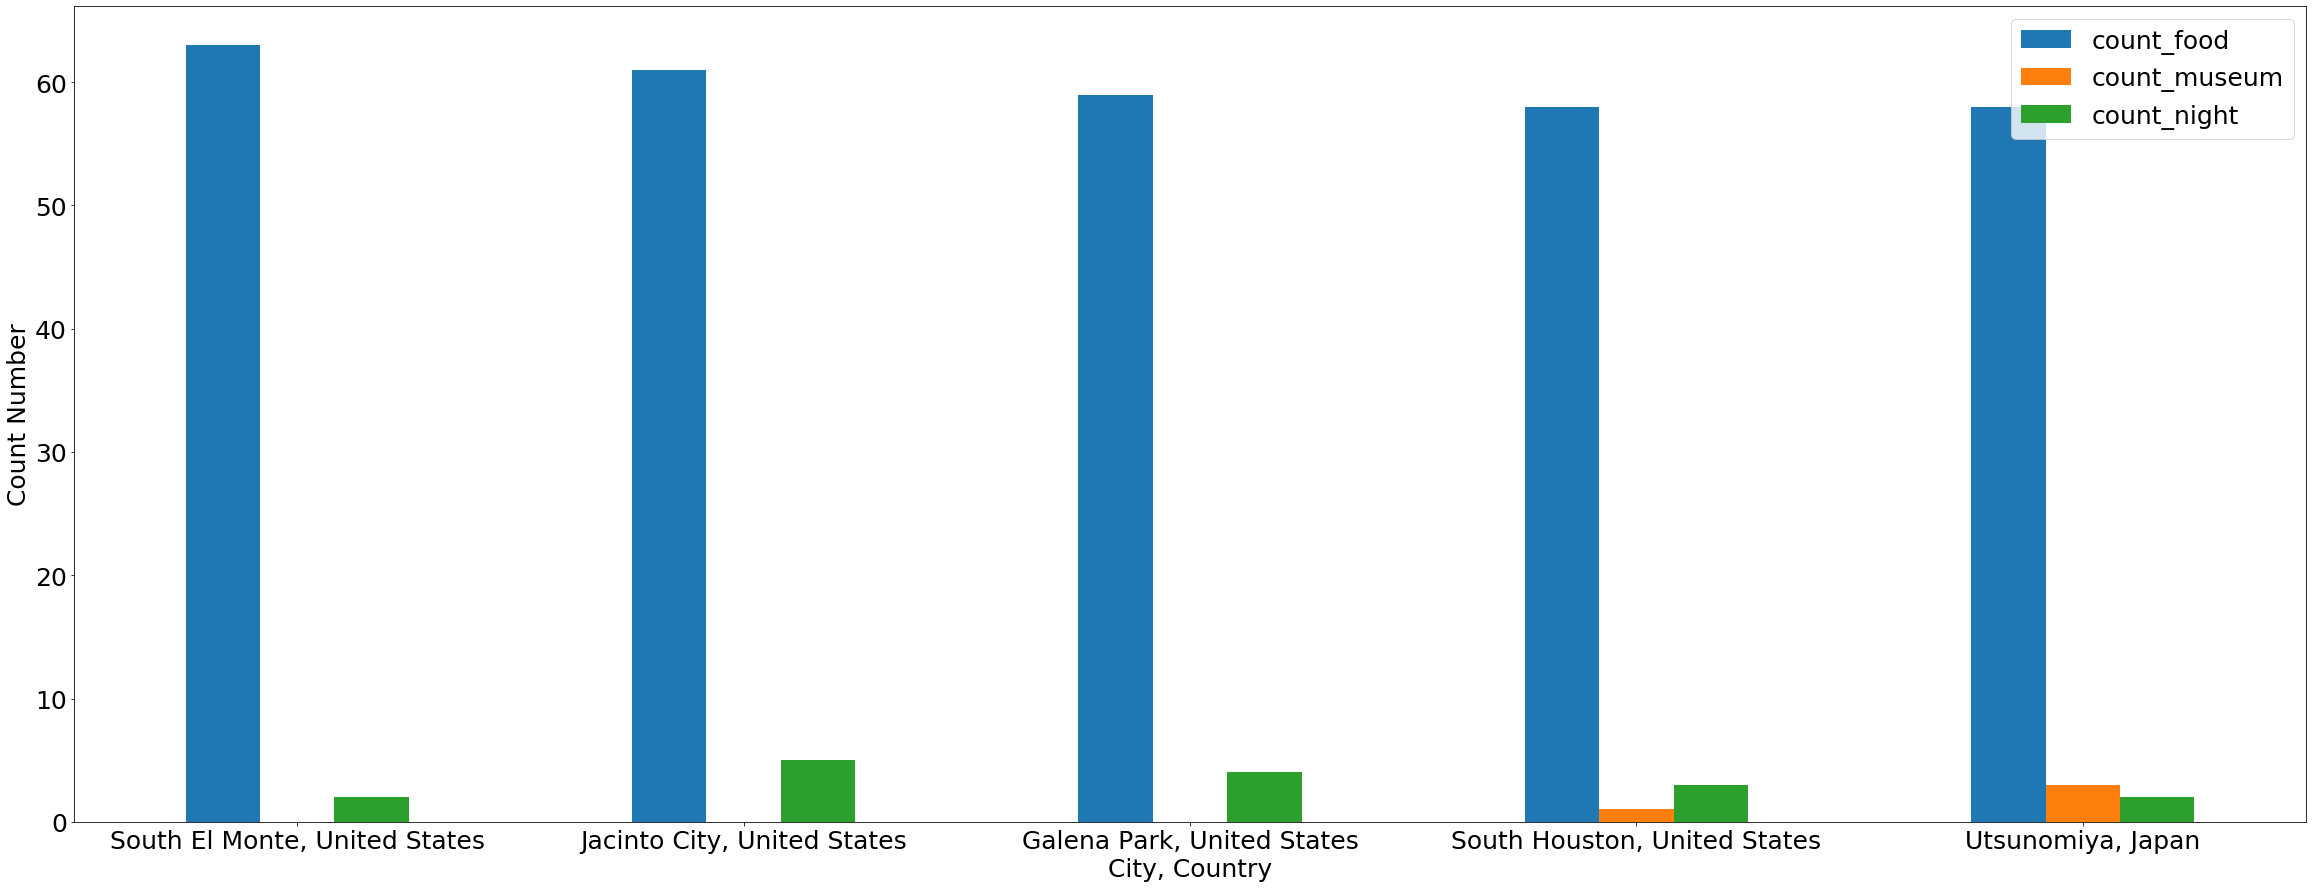

In [118]:
# Plot bar plot of the top 5 cities
city_plot = city_info[['city','count_food','count_museum','count_night','city, country']]
ax = city_plot.iloc[:5].plot.bar(rot=0,figsize=(40,15))
ax.set_xlabel('City, Country', size=25)
ax.set_ylabel('Count Number', size=25)
ax.set_xticklabels(city_plot['city, country'])
ax.tick_params(axis='both', which='major', labelsize=25)
ax.legend(fontsize=25)

When sorting cities based on the number of restaurants, we notice that the United states dominates this time the top 5 list. In addition, for the top 5 cities, the number of restaurants is incomparable to the number of museums or nightlife venues. In addition, the cities that made it to the top 5 are not that well-known to be destinations (judged by the total number of hotels), which can be an interesting suggestion for tourists to try new unknown restaurants.

Now K-means clustering algorithm in order to group the cities into clusters that have similar touristic destinations, however before doing that, the total number of venues that belong to each of the three categories (historical places/museums, bars\nightclubs and food) we have needs to be normalized due to the wide range of numbers we have.

#### Normalize each record of the dataframe

In [253]:
city_info[['ratio_food']] = city_info['count_food']/(city_info['count_food']+city_info['count_museum']+city_info['count_night'])
city_info['ratio_museum'] = city_info['count_museum']/(city_info['count_food']+city_info['count_museum']+city_info['count_night'])
city_info['ratio_night'] = city_info['count_night']/(city_info['count_food']+city_info['count_museum']+city_info['count_night'])

In [254]:
city_info.head()

,city,count_accom,count_food,count_museum,count_night,country,lat,lng,"city, country",ratio_food,ratio_museum,ratio_night
0,South El Monte,1,63,0,2,United States,34.0493,-118.0484,"South El Monte, United States",0.969231,0.000000,0.030769
1,Jacinto City,1,61,0,5,United States,29.7663,-95.2410,"Jacinto City, United States",0.924242,0.000000,0.075758
2,Galena Park,1,59,0,4,United States,29.7452,-95.2333,"Galena Park, United States",0.936508,0.000000,0.063492
3,South Houston,1,58,1,3,United States,29.6611,-95.2285,"South Houston, United States",0.935484,0.016129,0.048387
4,Utsunomiya,2,58,3,2,Japan,36.5500,139.8700,"Utsunomiya, Japan",0.920635,0.047619,0.031746


#### Cluster Touristic Destinations

In [297]:
# Run k-means to cluster the cities into 5 clusters.

# import k-means from clustering stage
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 4

grouped_clustering = city_info[['ratio_food','ratio_museum','ratio_night']]

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 1, 1, 3, 1, 1, 3, 3, 1, 3])

In [298]:
# Let's create a new dataframe that includes the cluster as well as the categories for each city

# add clustering labels
#city_info.insert(0, 'Cluster Labels', kmeans.labels_)

city_info_tot = city_info
city_info_tot['Cluster Labels'] = kmeans.labels_

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
#final_result = Toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')


In [300]:
# shuffle the dataset
city_info_tot.sample(random_state=0,frac=1).reset_index(drop=True)
#city_info_tot.drop(['city','country'],axis=1,inplace=True)
city_info_tot.head(20) # check the last columns!

,count_accom,count_food,count_museum,count_night,lat,lng,"city, country",ratio_food,ratio_museum,ratio_night,Cluster Labels
0,3,50,1,5,35.4480,-94.3529,"Van Buren, United States",0.892857,0.017857,0.089286,3
1,5,36,7,11,35.8869,14.4025,"Imdina, Malta",0.666667,0.129630,0.203704,1
2,4,36,6,9,4.5964,-74.0833,"Bogota, Colombia",0.705882,0.117647,0.176471,1
3,6,49,1,9,20.5504,-97.4700,"Poza Rica de Hidalgo, Mexico",0.830508,0.016949,0.152542,3
4,2,5,2,2,48.3318,40.2518,"Kamensk Shakhtinskiy, Russia",0.555556,0.222222,0.222222,1
5,3,37,5,16,37.6897,-97.3442,"Wichita, United States",0.637931,0.086207,0.275862,1
6,2,40,0,2,34.9514,-89.9787,"Southaven, United States",0.952381,0.000000,0.047619,3
7,5,37,1,5,26.0293,-80.1678,"Hollywood, United States",0.860465,0.023256,0.116279,3
8,7,37,14,7,37.5663,126.9997,"Seoul, Korea, South",0.637931,0.241379,0.120690,1
9,1,14,0,2,43.0282,-74.9928,"Herkimer, United States",0.875000,0.000000,0.125000,3


## Results

Let's check the characteristics of few cities that correspond to each of the 4 clusters. This gives us an idea of the the best type of tourism that can be done at the cities that belong to each of the clusters.

The results show the name of each of the city, the number of the cluster that denoted by the column 'Cluster_labels', the latitude and the longitude that can be used with Foursquare's API to get more details about specific cities. In addition, the ratio of the veneus that belong to each of the three categories we specified (historical places/museums, bars\nightclubs and food).

### Cluster 1

In [307]:
# Cluster 1
cluster1=city_info_tot.loc[city_info_tot['Cluster Labels'] == 0, city_info_tot.columns[[1] + list(range(4, city_info_tot.shape[1]))]]
cluster1.head(10)

,count_food,lat,lng,"city, country",ratio_food,ratio_museum,ratio_night,Cluster Labels
66,10,50.7004,-3.5300,"Exeter, United Kingdom",0.333333,0.066667,0.600000,0
125,0,-5.9897,39.2519,"Mahonda, Tanzania",0.000000,0.000000,1.000000,0
178,0,-0.5196,37.4500,"Embu, Kenya",0.000000,0.000000,1.000000,0
249,3,0.0204,37.0600,"Nanyuki, Kenya",0.428571,0.000000,0.571429,0
375,3,46.5103,15.0806,"Slovenj Gradec, Slovenia",0.375000,0.000000,0.625000,0
383,0,57.7647,36.6900,"Bezhetsk, Russia",0.000000,0.000000,1.000000,0
500,6,54.8800,-2.9300,"Carlisle, United Kingdom",0.315789,0.105263,0.578947,0
515,1,2.7800,32.2800,"Gulu, Uganda",0.333333,0.000000,0.666667,0
521,0,58.4503,-130.0333,"Dease Lake, Canada",0.000000,0.000000,1.000000,0
569,0,-20.0809,146.2587,"Charters Towers, Australia",0.000000,0.000000,1.000000,0


In [328]:
print('There are ', len(cluster1), ' cities that belong to cluster 1')

There are  204  cities that belong to cluster 1


## Cluster 2

In [308]:
# Cluster 2
cluster2 = city_info_tot.loc[city_info_tot['Cluster Labels'] == 1, city_info_tot.columns[[1] + list(range(4, city_info_tot.shape[1]))]]
cluster2.head(10)

,count_food,lat,lng,"city, country",ratio_food,ratio_museum,ratio_night,Cluster Labels
1,36,35.8869,14.4025,"Imdina, Malta",0.666667,0.129630,0.203704,1
2,36,4.5964,-74.0833,"Bogota, Colombia",0.705882,0.117647,0.176471,1
4,5,48.3318,40.2518,"Kamensk Shakhtinskiy, Russia",0.555556,0.222222,0.222222,1
5,37,37.6897,-97.3442,"Wichita, United States",0.637931,0.086207,0.275862,1
8,37,37.5663,126.9997,"Seoul, Korea, South",0.637931,0.241379,0.120690,1
14,5,54.8612,-6.2763,"Ballymena, United Kingdom",0.714286,0.000000,0.285714,1
16,38,41.6000,-87.6905,"Markham, United States",0.745098,0.019608,0.235294,1
18,8,46.4367,15.9536,"Dornava, Slovenia",0.615385,0.076923,0.307692,1
19,35,41.9663,-87.8057,"Harwood Heights, United States",0.729167,0.062500,0.208333,1
22,37,41.9193,-88.3110,"Saint Charles, United States",0.804348,0.000000,0.195652,1


In [332]:
print('There are ', len(cluster2), ' cities that belong to cluster 2')

There are  2835  cities that belong to cluster 2


### Cluster 3

In [309]:
# Cluster 3
cluster3 = city_info_tot.loc[city_info_tot['Cluster Labels'] == 2, city_info_tot.columns[[1] + list(range(4, city_info_tot.shape[1]))]]
cluster3.head(10)

,count_food,lat,lng,"city, country",ratio_food,ratio_museum,ratio_night,Cluster Labels
29,1,57.3364,23.1235,"Mersrags, Latvia",0.333333,0.666667,0.000000,2
49,1,28.6800,115.8800,"Nanchang, China",0.500000,0.500000,0.000000,2
65,0,39.4763,75.9699,"Kashgar, China",0.000000,1.000000,0.000000,2
80,12,40.8182,-74.0022,"Fairview, United States",0.428571,0.428571,0.142857,2
151,14,39.9272,32.8644,"Ankara, Turkey",0.311111,0.400000,0.288889,2
200,0,-28.8780,28.0560,"Hlotse, Lesotho",0.000000,1.000000,0.000000,2
215,1,55.9077,21.8456,"Plunge, Lithuania",0.333333,0.333333,0.333333,2
272,1,28.0304,73.3299,"Bikaner, India",0.333333,0.666667,0.000000,2
285,1,43.9443,116.0443,"Xilinhot, China",0.333333,0.666667,0.000000,2
338,14,25.7000,32.6500,"Luxor, Egypt",0.400000,0.542857,0.057143,2


In [333]:
print('There are ', len(cluster3), ' cities that belong to cluster 3')

There are  183  cities that belong to cluster 3


### Cluster 4

In [310]:
# Cluster 4
cluster4 = city_info_tot.loc[city_info_tot['Cluster Labels'] == 3, city_info_tot.columns[[1] + list(range(4, city_info_tot.shape[1]))]]
cluster4.head(10)

,count_food,lat,lng,"city, country",ratio_food,ratio_museum,ratio_night,Cluster Labels
0,50,35.4480,-94.3529,"Van Buren, United States",0.892857,0.017857,0.089286,3
3,49,20.5504,-97.4700,"Poza Rica de Hidalgo, Mexico",0.830508,0.016949,0.152542,3
6,40,34.9514,-89.9787,"Southaven, United States",0.952381,0.000000,0.047619,3
7,37,26.0293,-80.1678,"Hollywood, United States",0.860465,0.023256,0.116279,3
9,14,43.0282,-74.9928,"Herkimer, United States",0.875000,0.000000,0.125000,3
10,1,42.8071,22.3247,"Crna Trava, Serbia",1.000000,0.000000,0.000000,3
11,38,42.3765,-122.9109,"Central Point, United States",0.863636,0.000000,0.136364,3
12,38,42.5361,1.5828,"Encamp, Andorra",0.883721,0.000000,0.116279,3
13,37,41.7980,-87.9569,"Clarendon Hills, United States",0.822222,0.000000,0.177778,3
15,21,-25.3800,-51.4800,"Guarapuava, Brazil",0.840000,0.000000,0.160000,3


In [334]:
print('There are ', len(cluster4), ' cities that belong to cluster 4')

There are  3432  cities that belong to cluster 4


The first cluster includes mainly the cities that have higher ratio of venues that can be categorized as nightlife. As for the third cluster is dominated by the cities that have higher ratio of museums and historical places. While the fourth cluster is dominated by cities that have higher ratio of restuarants.

The second cluster contains cities that have almost equal ratios of nightlife venues, museums and historical places, while the ratio of restaurants are dominating.

The number of cities that belong to the clusters 2 and 3 are more than those that belong to clusters 1 and 4 and that is probably due to the fact that cities with higher ratio of restaurants are usually more than cities that have dominating ratios of nightlife and historical sites venues.

## Discussion

As I mentioned before, when travelling, different people come with different tastes. Some people travel to visit historical places and museums, others travel to spend time at famous bars or nightclubs, and more recently, more people have become interested in what is called 'Food Tourism'. 

Therefore, in this project I used K-means clustering algorithm to group different cities with different ratios of venues that belong to each of the three categories we had, into different clusters. The list of cities are obtained from online dataset, while the venues that exist in each city is obtained using Foursquare's API.

This can be interesting for tourists from all over the globe, who are willing to get some suggestions regarding cities to visit which satisfy their touristic interests. In addition, people willing to invest in any of these categories of tourism (historical places/museums, bars\nightclubs and food) can make use of it to choose cities where each of these categories is booming or those which the market that has not saturated yet and can still accept more investment to boom.

We had 6654 cities in total, of which 204 belong to the first cluster, 2835 cities belong to the second cluster, 183 cities belong to the third clusters and 3432 cities are in the fourth cluster. This result is expected, as usually the number of restaurants in most of the cities is huge, therefore these two clusters are dominated by the ratio of the food venues. While clusters 1 and 3 that dominated by cities that have nightlife and historic venues respectively have smaller sizes.


## Conclusion

Using the results of this project, people can have a better idea of what to expect when visiting certain cities, or can target specific cities when seeking a certain type of tourism (historical places/museums, bars/nightclubs and food) or investment. This helps makes things easier for strangers visiting different cities.

More work can be done to include more cities and to filter the venues to get only the trending ones or those with high number of tips.
